In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

# Otimizando Hiperparâmetros

## Carregando e pré-processando Ames Housing

In [2]:
tb_housing = pd.read_csv("data/tb_ames_housing.csv")
tb_housing = tb_housing.dropna(axis=1)
tb_housing = tb_housing.drop("Id", axis=1)


In [3]:
tb_housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   LotArea        1460 non-null   int64 
 3   Street         1460 non-null   object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  OverallQual    1460 non-null   int64 
 15  OverallCond    1460 non-null   int64 
 16  YearBuilt      1460 non-null   int64 
 17  YearRemodAdd   1460 non-null   int64 
 18  RoofStyle      1460 non-null

Vamos separar as variáveis numéricas e categóricas, guardando os nomes de cada coluna e duas listas distintas.

In [4]:
cat_vars = list(tb_housing.select_dtypes("object").columns)
num_vars = list(tb_housing.select_dtypes(include=np.number).drop("SalePrice", axis=1).columns)

In [6]:
num_vars

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

Agora vamos utilizar criar um OneHotEncoder capaz de lidar com os features salvos na lista `cat_vars`

In [7]:
ohe_fit = OneHotEncoder(drop="first", sparse = False)
ohe_fit.fit(tb_housing[cat_vars])


OneHotEncoder(drop='first', sparse=False)

Vamos separar o conjunto de treinamento e teste e criar um StandardScaler a partir dos dados de treinamento. Após a separação vamos criar uma nova matriz de dados através da concatenação das variáveis categóricas codificadas como variáveis binárias e das variáves numéricas normalizadas.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(tb_housing[cat_vars + num_vars], tb_housing['SalePrice'], test_size = 0.15, random_state = 42)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train[num_vars])

StandardScaler()

In [10]:
X_train_t = np.column_stack([scaler.transform(X_train[num_vars]), ohe_fit.transform(X_train[cat_vars])])
X_test_t = np.column_stack([scaler.transform(X_test[num_vars]), ohe_fit.transform(X_test[cat_vars])])

## Visualizando overfitting

Como vimos nas últimas semanas, os algoritmos de ML são muito diferentes das regressões linear e logistica: enquanto estes modelos simples são definidos pelas variáveis de entrada, os modelos de ML são definidos também por hiperparâmetros. Também vimos que métodos como as árvores de decisão são muitas vezes capaz de explicar *perfeitamente* os dados de treinamento sem que isso se reflita no conjunto de teste.

Essa capacidade dos modelos de ML de aprenderem estruturas complexas é ao mesmo tempo seu ponto forte e um risco: se ajustarmos os parâmetros de um modelo erroneamente podemos terminar achando que o modelo tem uma performance muito melhor do que realmente terá. A divisão em conjuntos de treinamento e teste mitiga muito desse risco, mas não nos dá, a priori, uma forma de encontrar o melhor conjunto de parâmetros para um dado problema.

Nesta seção vamos visualizar como o overfitting acontece comparando o erro no conjunto de treinamento e o erro no conjunto de teste. A partir desse entendimento poderemos traçar estratégias para encontrar o melhor conjunto de hiperparâmetros para nossos dados sem que soframos nem com underfitting (variáveis tem mais poder explicativo do que modelo representa) ou overfitting (modelo não generaliza).

In [11]:
depth_optim = [int(x) for x in np.linspace(1, 20, 20)]



In [12]:
depth_optim

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [13]:
erro_train_list = []
erro_test_list = []
depth_list = []
for depth in depth_optim:
    tree_fit = DecisionTreeRegressor(max_depth = depth)
    tree_fit.fit(X_train_t, y_train)
    erro_train = mean_squared_error(y_train, tree_fit.predict(X_train_t))
    erro_test = mean_squared_error(y_test, tree_fit.predict(X_test_t))
    erro_train_list.append(erro_train)
    erro_test_list.append(erro_test)
    depth_list.append(depth)

Assim como nas tarefas de classificação, a complexidade de uma árvore de decisão é ligada, principalmente, à três parâmetros fundamentais:

* **max_depth**: a profundidade máxima da árvore, medida em número de splits entre as folhas e a raiz;
* **min_samples_split**: o menor número de pontos necessário em um galho para que um split seja feito;
* **min_samples_leaf**: o menor número de pontos em cada folha.

Conforme aumentamos a `max_depth` e diminuimos o `min_samples_split` e `min_samples_leaf` aumentamos a complexidade de nossa árvore e, como em qualquer modelo, conforme aumentamos a complexidade aumentamos o risco  de sofrer com overfitting. No código acima variamos a complexidade da árvore aumentando sua profundidade de 1 à 20. Vamos visualizar o overfitting comparando o erro do modelo no conjunto de teste contra o conjunto de treinamento conforme aumentamos a complexidade:

<AxesSubplot:xlabel='depth', ylabel='erro_train_list'>

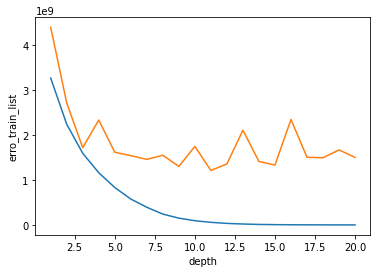

In [14]:
tb_overfit = pd.DataFrame({'depth' : depth_list, 'erro_train_list' : erro_train_list, 'erro_test_list' : erro_test_list})
sns.lineplot(data = tb_overfit, x= 'depth', y= 'erro_train_list')
sns.lineplot(data = tb_overfit, x= 'depth', y= 'erro_test_list')

Comoi podemos ver, inicialmente o aumento de complexidade da árvore reduz o erro tanto no conjunto de teste quanto no conjunto de treinamento. Conforme a complexidade aumenta, a velocidade de melhoría no conjunto teste cai, até que se estabiliza (e muitas vezes vemos o erro crescer a partir deste ponto).

O melhor modelo é aquele que tem o melhor erro (aproveita toda informação disponível) e a menor complexidade (maior capacidade de generalização). No gráfico acima podemos ver que, no caso atual, a árvore com profundidade 4 se aproxima desse ideal.

In [15]:
tree_fit = DecisionTreeRegressor(max_depth = 6)
tree_fit.fit(X_train_t, y_train)
erro_train = mean_squared_error(y_train, tree_fit.predict(X_train_t))
erro_test = mean_squared_error(y_test, tree_fit.predict(X_test_t))
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

RMSE Train: 24040.69675820914
RMSE Test: 38326.34099761229


## Utilizando o gridsearch para automatizar a busca

A tarefa realizada acima através de um loop é tão comum que podemos utilizar uma série de funções específicas para realizar a avaliação automática de hiperparâmetros. Alguns nomes importantes nesse processo:

* **Espaço de Hiperparâmetros**: no exemplo acima varíamos apenas a profundidade da árvore que estávamos construindo - neste caso o espaço de hiperparâmetros era o vetor [1, 2, 3 ... 19, 20] (`np.linspace(1, 20, 20)`). Veremos abaixo um exemplo onde este espaço é composto por mais vetores.
* **Busca com Validação Cruzada**: para manter o nosso conjunto teste original fora da busca de hiperparâmetros utilizaremos validação cruzada no conjunto de treinamento - para cada combinação possível dos nossos vetores de hiperparâmetros construiremos 5 conjuntos de teste sobre o qual avaliaremos o modelo. Utilizaremos esses 5 conjuntos para calcular o erro médio associado à um conjunto de hiperparâmetros.

In [16]:
from sklearn.model_selection import GridSearchCV

Primeiro vamos usar o `GridSearchCV` para realizar a avaliação que fizemos através do loop acima.

In [17]:
param_grid = {
    'max_depth' : [int(x) for x in np.linspace(1, 20, 20)]
}
tree_fit = DecisionTreeRegressor()
grid_fit = GridSearchCV(tree_fit, param_grid, cv = 5)
grid_fit.fit(X_train_t, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]})

In [19]:
grid_fit.best_params_

{'max_depth': 13}

In [20]:
erro_train = mean_squared_error(y_train, grid_fit.predict(X_train_t))
erro_test = mean_squared_error(y_test, grid_fit.predict(X_test_t))
print(grid_fit.best_estimator_)
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

DecisionTreeRegressor(max_depth=13)
RMSE Train: 4617.990797633116
RMSE Test: 39536.94510614732


O `GridSearchCV` tem duas grandes vantagens sobre o nosso loop original:

1. Realiza automaticamente a busca utilizando validação cruzada;
1. Cria automaticamente espaços de parâmetros mais complexos.

Para entender melhor o segundo ponto vamos expandir nossa busca para contemplar os outros 2 hiperparâmetros fundamentais de complexidade das árvores de decisão (`min_samples_split` e `min_samples_leaf`).

In [21]:
param_grid = {
    'max_depth' : [int(x) for x in np.linspace(1, 50, 10)],
    'min_samples_split' : [int(x) for x in np.linspace(2, 40, 10)],
    'min_samples_leaf' : [int(x) for x in np.linspace(1, 20, 10)]
}
tree_fit = DecisionTreeRegressor()
grid_fit = GridSearchCV(tree_fit, param_grid, cv = 50)
grid_fit.fit(X_train_t, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 6, 11, 17, 22, 28, 33, 39, 44, 50],
                         'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                              20],
                         'min_samples_split': [2, 6, 10, 14, 18, 23, 27, 31, 35,
                                               40]})

In [23]:
grid_fit.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 44,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 23,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

O espaço de hiperparâmetros definido acima não é composto apenas por um vetor, mas por um **grade**: o `GridSearchCV` vai testar todos os pontos dessa grade, ou seja, todas as combinações de hiperparâmetros possíveis a partir dos vetores definidos dentro do dicionário `param_grid`.

Podemos utilizar o atributo `.cv_results_` para acessar os resultados de cada fit feito pela busca. Temos que tomar cuidado com o erro apresentado aqui: ele é o `MSE * -1`, ou seja, quanto maior, melhor.

In [24]:
tb_gridfit = pd.DataFrame(grid_fit.cv_results_)

In [25]:
tb_gridfit.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004385,0.001115,0.000772,0.000230,1,1,2,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...",0.470477,0.527107,0.346617,0.447044,0.478026,0.453854,0.05962,901
1,0.002882,0.000302,0.000563,0.000158,1,1,6,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...",0.470477,0.527107,0.346617,0.447044,0.478026,0.453854,0.05962,901
2,0.002256,0.000119,0.000366,0.000031,1,1,10,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...",0.470477,0.527107,0.346617,0.447044,0.478026,0.453854,0.05962,901
3,0.002046,0.000099,0.000420,0.000072,1,1,14,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...",0.470477,0.527107,0.346617,0.447044,0.478026,0.453854,0.05962,901
4,0.001949,0.000093,0.000360,0.000065,1,1,18,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s...",0.470477,0.527107,0.346617,0.447044,0.478026,0.453854,0.05962,901


In [27]:
tb_gridfit.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
805,0.009674,0.000350,0.000292,0.000050,44,1,23,"{'max_depth': 44, 'min_samples_leaf': 1, 'min_...",0.768994,0.755465,0.745552,0.767450,0.745381,0.756569,0.010203,1
734,0.008887,0.000209,0.000272,0.000027,39,7,18,"{'max_depth': 39, 'min_samples_leaf': 7, 'min_...",0.733216,0.752690,0.735512,0.766098,0.791607,0.755825,0.021539,2
934,0.008892,0.000120,0.000260,0.000031,50,7,18,"{'max_depth': 50, 'min_samples_leaf': 7, 'min_...",0.733216,0.752447,0.735512,0.766098,0.791607,0.755776,0.021546,3
234,0.008649,0.000245,0.000251,0.000035,11,7,18,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_...",0.733216,0.752082,0.735855,0.765036,0.792090,0.755656,0.021558,4
434,0.008721,0.000218,0.000223,0.000003,22,7,18,"{'max_depth': 22, 'min_samples_leaf': 7, 'min_...",0.732119,0.752690,0.735512,0.765683,0.791607,0.755522,0.021733,5


Podemos utilizar gráficos e estatisticas descritivas para entender se a nossa busca foi suficiente ou se devemos extende-la em alguma direção não explorada.

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

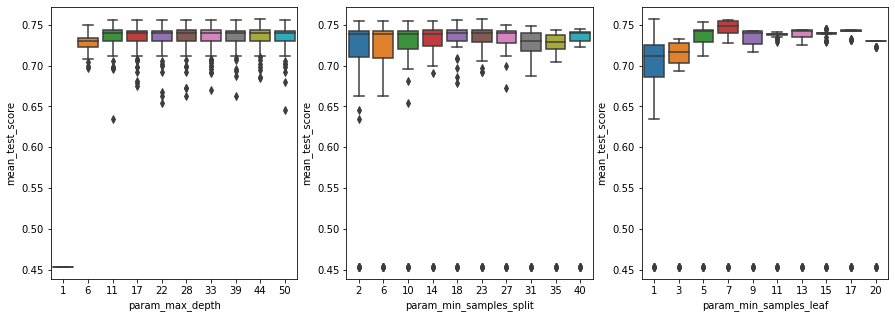

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
sns.boxplot(data = tb_gridfit, x = 'param_max_depth', y = 'mean_test_score', ax = ax[0])
sns.boxplot(data = tb_gridfit, x = 'param_min_samples_split', y = 'mean_test_score', ax = ax[1])
sns.boxplot(data = tb_gridfit, x = 'param_min_samples_leaf', y = 'mean_test_score', ax = ax[2])

No gráfico acima podemos ver um gap do espaço contruído: temos poucas árvores de baixa profundidade (nenhuma entre 0 e 6 por exemplo). Como as buscas exaustivas são computacionalmente caras, podemos acabar deixando buracos inadivertidamente na grade de hiperparâmetros.

Abaixo veremos uma segunda forma de fazer esta busca que nos permite aumentar os vetores percorridos sem aumentar o custo da busca.

In [29]:
erro_train = mean_squared_error(y_train, grid_fit.predict(X_train_t))
erro_test = mean_squared_error(y_test, grid_fit.predict(X_test_t))
print(grid_fit.best_estimator_)
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

DecisionTreeRegressor(max_depth=44, min_samples_split=23)
RMSE Train: 19930.543203695706
RMSE Test: 34649.58824216587


## Usando buscas aleatória para acelerar o processo

Ao invés de buscar exaustivamente todas as combinações, muitas vezes o ideal é começar utilizando uma busca aleatória: ao invés de buscar exaustivamente a grade de hiperparâmetros vamos *sortear* pontos dentro dessa grade para serem testados. As buscas aleatórias nos permitem percorrer um espaço maior com o mesmo custo que a busca exaustiva. No entanto podemos deixar passar o ponto *realmente ótimo* caso ele não seja sorteado. Por isso muitas vezes utilizamos uma busca aleatória para encontrar as melhores regiões no espaço de hiperparâmetros e então realizar buscas exaustivas nestas regiões.

Vamos usar o `RandomizedSearchCV` para buscar um espaço maior de hiperparâmetros. A única diferença para o `GridSearchCV` é o parâmetro `n_iter = 1000` que define quantos pontos serão amostrados em nosso processo de busca.

In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [31]:
param_grid = {
    'max_depth' : range(1, 150),
    'min_samples_split' : range(2, 40),
    'min_samples_leaf' : range(1, 20)
}
tree_fit = DecisionTreeRegressor()
grid_fit = RandomizedSearchCV(tree_fit, param_grid, cv = 5, n_iter = 1000)
grid_fit.fit(X_train_t, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=1000,
                   param_distributions={'max_depth': range(1, 150),
                                        'min_samples_leaf': range(1, 20),
                                        'min_samples_split': range(2, 40)})

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

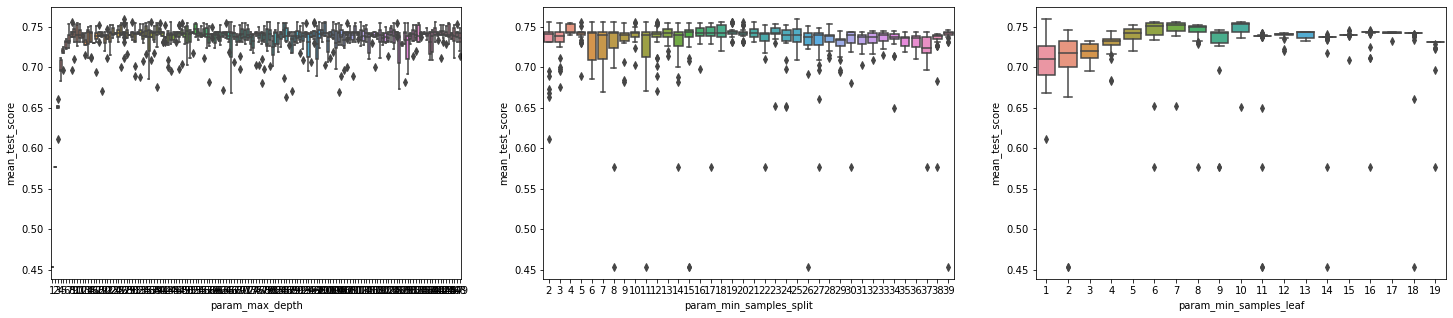

In [32]:
tb_gridfit = pd.DataFrame(grid_fit.cv_results_)
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
sns.boxplot(data = tb_gridfit, x = 'param_max_depth', y = 'mean_test_score', ax = ax[0])
sns.boxplot(data = tb_gridfit, x = 'param_min_samples_split', y = 'mean_test_score', ax = ax[1])
sns.boxplot(data = tb_gridfit, x = 'param_min_samples_leaf', y = 'mean_test_score', ax = ax[2])

Como nosso espaço é muito grande, os gráficos não são mais tão informativos... Podemos analisar os 10 melhores modelos que a busca aleatória encontrou.

In [33]:
tb_gridfit.sort_values('mean_test_score', ascending= False).head(10)[['param_min_samples_split', 'param_min_samples_leaf', 'param_max_depth', 'mean_test_score']]

,param_min_samples_split,param_min_samples_leaf,param_max_depth,mean_test_score
719,25,1,27,0.759086
70,2,6,79,0.756154
42,20,7,36,0.756130
469,7,6,80,0.756109
762,10,10,8,0.756027
307,2,6,90,0.756025
294,19,7,96,0.755967
935,19,7,100,0.755967
841,6,6,98,0.755937
105,11,6,66,0.755873


In [34]:
erro_train = mean_squared_error(y_train, grid_fit.predict(X_train_t))
erro_test = mean_squared_error(y_test, grid_fit.predict(X_test_t))
print(grid_fit.best_estimator_)
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

DecisionTreeRegressor(max_depth=27, min_samples_split=25)
RMSE Train: 21072.72818635488
RMSE Test: 36284.67442537738


In [35]:
[1] + [1] + [1]

[1, 1, 1]

In [39]:
param_grid = {
    'max_depth' : [4, 5, 6, 7] + [int(x) for x in np.linspace(11, 22, 5)] + [int(x) for x in np.linspace(30, 50, 5)] + [None],
    'min_samples_split' : [1] + [int(x) for x in np.linspace(5, 15, 5)] + [int(x) for x in np.linspace(18, 26, 5)],
    'min_samples_leaf' : [1] + [int(x) for x in np.linspace(5, 20, 10)]
}
tree_fit = DecisionTreeRegressor()
grid_fit = GridSearchCV(tree_fit, param_grid, cv = 5)
grid_fit.fit(X_train_t, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 11, 13, 16, 19, 22, 30, 35,
                                       40, 45, 50, None],
                         'min_samples_leaf': [1, 5, 6, 8, 10, 11, 13, 15, 16,
                                              18, 20],
                         'min_samples_split': [1, 5, 7, 10, 12, 15, 18, 20, 22,
                                               24, 26]})

In [40]:
erro_train = mean_squared_error(y_train, grid_fit.predict(X_train_t))
erro_test = mean_squared_error(y_test, grid_fit.predict(X_test_t))
print(grid_fit.best_estimator_)
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

DecisionTreeRegressor(max_depth=45, min_samples_split=20)
RMSE Train: 17674.865239911633
RMSE Test: 46207.35588346083


## Otimizando etapas de pré-processamento

Já vimos alguma formas de pré-processamento que também tem hiperparâmetros que causam impactos sobre o erro do modelo. Até agora vimos apenas técnicas de determinação desses atributos com base em características intrinsicas do modelo sendo aplicado (por exemplo, análise de variância representada quando utilizamos PCA). Vamos construir uma forma de inserir estes parâmetros no GridSearchCV.

### Pipelines de Modelagem - Simples

Para fazer isso vamos utilizar pipelines - funções que agregam métodos de transformação, pré-processamento e modelos em uma única interface de train e predict. Vamos começar com um exemplo simples, utilizando PCA sobre as variáveis numéricas de nosso dataset, para tratar as muitas colinearidades presentes que estão causando problemas até no tuning.

In [41]:
from sklearn.pipeline import Pipeline

In [47]:
scaler = StandardScaler()
pca = PCA()
tree_fit = DecisionTreeRegressor()

pipeline = Pipeline([('SCALING', scaler), ('PCA', pca), ('MODEL', tree_fit)])

Agora com nosso pipeline definido, vamos utiliza-lo como se fosse um modelo normal!

In [44]:
X_train, X_test, y_train, y_test = train_test_split(tb_housing[num_vars], tb_housing['SalePrice'], test_size = 0.2, random_state = 42)

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('SCALING', StandardScaler()), ('PCA', PCA()),
                ('MODEL', DecisionTreeRegressor())])

In [46]:
erro_train = mean_squared_error(y_train, pipeline.predict(X_train))
erro_test = mean_squared_error(y_test, pipeline.predict(X_test))
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

RMSE Train: 171.72822188499134
RMSE Test: 50121.935103784104


In [48]:
param_grid = {
    'PCA__n_components' : range(1, len(num_vars)), 
    'MODEL__max_depth' : range(1, 150),
    'MODEL__min_samples_split' : range(2, 40),
    'MODEL__min_samples_leaf' : range(1, 20),
}

grid_fit = RandomizedSearchCV(pipeline, param_grid, cv = 5, n_iter = 1000)
grid_fit.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('SCALING', StandardScaler()),
                                             ('PCA', PCA()),
                                             ('MODEL',
                                              DecisionTreeRegressor())]),
                   n_iter=1000,
                   param_distributions={'MODEL__max_depth': range(1, 150),
                                        'MODEL__min_samples_leaf': range(1, 20),
                                        'MODEL__min_samples_split': range(2, 40),
                                        'PCA__n_components': range(1, 33)})

In [49]:
erro_train = mean_squared_error(y_train, grid_fit.predict(X_train))
erro_test = mean_squared_error(y_test, grid_fit.predict(X_test))
print(grid_fit.best_params_)
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

{'PCA__n_components': 5, 'MODEL__min_samples_split': 36, 'MODEL__min_samples_leaf': 13, 'MODEL__max_depth': 104}
RMSE Train: 28764.545006194723
RMSE Test: 35264.14234274874


### Pipelines de Modelagem - Compostas

Agora vamos construir um pipeline capaz de lidar de forma independente com dados categóricos e numéricos.

In [51]:
from sklearn.compose import ColumnTransformer

In [52]:
X_train, X_test, y_train, y_test = train_test_split(tb_housing[num_vars+cat_vars], tb_housing['SalePrice'], test_size = 0.2, random_state = 42)

In [53]:
scaler = StandardScaler()
pca_num = PCA()
num_pipeline = Pipeline([('SCALER', scaler), ('PCA', pca_num)])

Iniciamos um pipeline, `num_pipeline`, para tratar exclusivamente de variáveis numéricas. Vamos criar o outro braço do nosso pipeline completo.

In [54]:
from sklearn.feature_selection import SelectKBest, f_regression, chi2

Vamos utilizar a função `SelectKBest` para selecionar as principais variáveis dummies que impactam nossa variável resposta. Vamos utilizar o GridSearch para otimizar o K (número de variáveis que manteremos no modelo).

In [55]:
ohe = OneHotEncoder(drop = 'first', handle_unknown="ignore")
kbest = SelectKBest(score_func = f_regression)
cat_pipeline = Pipeline([('OHE', ohe), ('KB', kbest)])

Vamos construir a etapa de pré-processamento de dados do pipeline utilizando um `ColumnTransformer` que nos permite especificar não só o nome e função de cada etapa do pipeline mas também quais variáveis são tratadas por cada etapa. Abaixo criamos o braço `NUMPREP` para lidar com variáveis numéricas e o braço `CATPREP` para lidar com variáveis categóricas.

In [56]:
dataprep = ColumnTransformer(transformers=[('NUMPREP', num_pipeline, num_vars),
                                           ('CATPREP', cat_pipeline, cat_vars)])


In [57]:
tree_fit = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('PRE', dataprep),
                           ('MODEL', tree_fit)])

In [58]:
param_grid = {
    'PRE__NUMPREP__PCA__n_components' : range(1, len(num_vars)),
    'PRE__CATPREP__KB__k' : range(1, len(cat_vars)),
    'MODEL__max_depth' : range(1, 150),
    'MODEL__min_samples_split' : range(2, 40),
    'MODEL__min_samples_leaf' : range(1, 20),
}

grid_fit = RandomizedSearchCV(pipeline, param_grid, cv = 5, n_iter = 5000)
grid_fit.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('PRE',
                                              ColumnTransformer(transformers=[('NUMPREP',
                                                                               Pipeline(steps=[('SCALER',
                                                                                                StandardScaler()),
                                                                                               ('PCA',
                                                                                                PCA())]),
                                                                               ['MSSubClass',
                                                                                'LotArea',
                                                                                'OverallQual',
                                                                                'OverallCond',
                           

In [59]:
erro_train = mean_squared_error(y_train, grid_fit.predict(X_train))
erro_test = mean_squared_error(y_test, grid_fit.predict(X_test))
print(grid_fit.best_params_)
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

{'PRE__NUMPREP__PCA__n_components': 5, 'PRE__CATPREP__KB__k': 12, 'MODEL__min_samples_split': 32, 'MODEL__min_samples_leaf': 13, 'MODEL__max_depth': 19}
RMSE Train: 28428.630609927262
RMSE Test: 36247.690224305494


## Utilizando Pipelines com XGBoost

Nas últimas aulas vimos que podemos ir além da SKLEARN e utilizar modelos de ponta dentro do Python através da biblioteca catboost. Atualmente, 3 algoritmos são dominantes em termos de capacidade preditiva: catboost, XGBoost e LightGBM. Vimos como utilizar o catboost para criar modelos de boosting robustos, utilizando o early stopping para impedir o overfitting.

Hoje vamos utilizar a XGBoost através de sua biblioteca Python. Como esta biblioteca fornece uma interface compatível com a SKLEARN, poderemos incluir o `XGBRegressor` em nosso pipeline preditivo.

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

In [60]:
import xgboost as xgb

Vamos inicializar um novo pipeline com o XGBoost na etapa `MODEL`

In [61]:
xgb_fit = xgb.XGBRegressor(n_jobs = -1)
pipeline = Pipeline(steps=[('PRE', dataprep),
                           ('MODEL', xgb_fit)])

O algoritmo XGBoost, assim como o catboost, é enorme e permite um altissimo grau de customização - permitindo a construção de modelos específicos para cada problema que precisarmos resolver. No entanto, essa flexibilidade tem um custo: complexidade. Primeiro, vamos lembrar que a complexidade de todo modelo de ensemble é ligada à dois fatores distintos: penalização de estimadores fracos individuais e penalizações gerais.

Primeiro, vamos analisar 4 hiperparâmetros que controlam a complexidade do modelo ao longo desses dois eixos:
* **max_depth**: profundidade máxima de cada estimador fraco **(penalização de estimador fraco)**. **QUANTO MAIOR, MAIS COMPLEXO, MAIS OVERFITTING**.
* **min_child_weight**: um limite de pureza que o modelo busca em cada folha de cada árvore construída **(penalização de estimador fraco)**. **QUANTO MENOR, MAIS COMPLEXO, MAIS OVERFITTING**.
* **gamma**: controla a complexidade de cada estimador com base na complexidade do modelo completo - conforme adicionamos árvores aumentamos o custo de novas árvores terem muitas folhas **(penalização geral)**. **QUANTO MENOR, MAIS COMPLEXO, MAIS OVERFITTING**.
* **n_estimators**: o número de estimadores fracos que serão construídos **(penalização geral)**. **QUANTO MAIOR, MAIS COMPLEXO, MAIS OVERFITTING**.

Além disso, o XGBoost realiza a construção de cada novo estimador sobre uma amostra dos dados completa. Podemos reduzir a chance de overfitting alterando 3 parâmetros chaves relativos a esse processo:


* **eta**: taxa de aprendizagem, o quanto cada etapa de boosting pode contributir ao modelo. Idealmente queremos um eta baixo e um num_rounds alto, embora isso encorra em custos computacionais maiores. **QUANTO MAIOR, MAIS RÁPIDO, MAIS OVERFITTING**.
* **subsample**: % da base completa de treinamento que o XGBoost utiliza para construir cada estimador fraco. **QUANTO MAIOR, MAIS RÁPIDO, MAIS OVERFITTING**.
* **colsample_bytree**: % dos features que o XGBoost utilizará para construir cada estimador fraco. **QUANTO MAIOR, MAIS RÁPIDO, MAIS OVERFITTING**.

In [66]:
param_grid = {
    'PRE__NUMPREP__PCA__n_components' : range(1, len(num_vars)),
    'PRE__CATPREP__KB__k' : range(1, len(cat_vars)),
    'MODEL__max_depth' : range(1, 10),
    'MODEL__eta' : np.linspace(0.01, 1, 100), 
    "MODEL__min_child_weight": np.linspace(0.01, 5, 100),          
    "MODEL__gamma": np.linspace(0.01, 5, 100),                     
    "MODEL__colsample_bytree" : np.linspace(0.6, 0.9, 100),                
    'MODEL__subsample':np.linspace(0.4, 0.8, 100),
    'MODEL__n_estimators':[int(x) for x in np.linspace(5, 250, 100)],
}

grid_fit = RandomizedSearchCV(pipeline, param_grid, cv = 5, n_iter = 500)
grid_fit.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('PRE',
                                              ColumnTransformer(transformers=[('NUMPREP',
                                                                               Pipeline(steps=[('SCALER',
                                                                                                StandardScaler()),
                                                                                               ('PCA',
                                                                                                PCA())]),
                                                                               ['MSSubClass',
                                                                                'LotArea',
                                                                                'OverallQual',
                                                                                'OverallCond',
                           

In [68]:
import sys
print(sys.maxsize)

9223372036854775807


In [67]:
erro_train = mean_squared_error(y_train, grid_fit.predict(X_train))
erro_test = mean_squared_error(y_test, grid_fit.predict(X_test))
print(grid_fit.best_params_)
print(f"RMSE Train: {np.sqrt(erro_train)}\nRMSE Test: {np.sqrt(erro_test)}")

{'PRE__NUMPREP__PCA__n_components': 6, 'PRE__CATPREP__KB__k': 24, 'MODEL__subsample': 0.4484848484848485, 'MODEL__n_estimators': 99, 'MODEL__min_child_weight': 4.697575757575758, 'MODEL__max_depth': 5, 'MODEL__gamma': 4.8487878787878795, 'MODEL__eta': 0.05, 'MODEL__colsample_bytree': 0.893939393939394}
RMSE Train: 22145.259306179276
RMSE Test: 32210.48032166388


In [ ]:
'''
param = {
    'eta': 0.10,                      # Lower ratios avoid over-fitting. Default is 3.
    'max_depth': 30,                  # Lower ratios avoid over-fitting. Default is 6.
    "min_child_weight": 3,            # Larger ratios avoid over-fitting. Default is 1.
    "gamma": 0.3,                     # Larger values avoid over-fitting. Default is 0. 
    "colsample_bytree" : 0.7,         # Lower ratios avoid over-fitting. Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
    "reg_lambda": 10,                 # Larger ratios avoid over-fitting. Default is 1.
    "alpha": 1,                       # Larger ratios avoid over-fitting. Default is 0.
    'subsample':0.5,                  # Lower ratios avoid over-fitting. Default 1. 0.5 recommended.
    'num_parallel_tree': 2,           # Parallel trees constructed during each iteration. Default is 1
}

testar com n_estimators de 200 à 600, especialmente para classificação
'''